<a href="https://colab.research.google.com/github/sagerpascal/first-order-model/blob/master/presentation/presentation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install https://download.pytorch.org/whl/cu90/torch-1.0.0-cp36-cp36m-linux_x86_64.whl

In [3]:
%cd /content/gdrive/My Drive/first-order-model

/content/gdrive/My Drive/first-order-model


In [4]:
!pip install -r requirements.txt

In [5]:
%cd /content/gdrive/My Drive/first-order-model/face-alignment

/content/gdrive/My Drive/first-order-model/face-alignment


In [6]:
!pip install -r requirements.txt
!python setup.py install

running install
running bdist_egg
running egg_info
writing face_alignment.egg-info/PKG-INFO
writing dependency_links to face_alignment.egg-info/dependency_links.txt
writing requirements to face_alignment.egg-info/requires.txt
writing top-level names to face_alignment.egg-info/top_level.txt
reading manifest file 'face_alignment.egg-info/SOURCES.txt'
writing manifest file 'face_alignment.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/face_alignment
copying build/lib/face_alignment/__init__.py -> build/bdist.linux-x86_64/egg/face_alignment
copying build/lib/face_alignment/utils.py -> build/bdist.linux-x86_64/egg/face_alignment
copying build/lib/face_alignment/api.py -> build/bdist.linux-x86_64/egg/face_alignment
copying build/lib/face_alignment/models.py -> build/bdist.linux-x86_64/egg/face_alignment
creating build/bdist.linux-x86_64/egg/face_alig

In [3]:
%cd /content/gdrive/My Drive/first-order-model

/content/gdrive/My Drive/first-order-model


In [6]:
import os

files_to_remove = ['crop.mp4', 'result.mp4', 'finished_video.mp4']

for f in files_to_remove:
  try:
    os.remove(f)
  except Exception as e:
    print(e)


[Errno 2] No such file or directory: 'crop.mp4'
[Errno 2] No such file or directory: 'result.mp4'
[Errno 2] No such file or directory: 'finished_video.mp4'


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import matplotlib.pyplot as plt
import skimage
import imageio
import math
import face_alignment
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import HTML
from base64 import b64encode

import os
import yaml
from tqdm import tqdm

from skimage.transform import resize
from skimage import img_as_ubyte
import torch
from sync_batchnorm import DataParallelWithCallback

from modules.generator import OcclusionAwareGenerator
from modules.keypoint_detector import KPDetector
from animate import normalize_kp
from scipy.spatial import ConvexHull


%matplotlib inline


In [10]:
def plot_images(images, bboxes=None, titles=None):
    fig = plt.figure(figsize=(15, 15))
    n_row = 4
    n_col = math.ceil(len(images) / n_row)
    for i, im in enumerate(images):
        ax = plt.subplot(n_col, n_row, i+1)
        ax.imshow(im)
        if titles is not None:
            ax.set_title(titles[i])
        if bboxes is not None:
            (x1, y1, x2, y2) = bboxes[i].flatten()
            rect = mpatches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
    plt.show()

# Quellen

- Siarohin, A & Lathuilière, S & Tulyakov, S & Ricci, E & Sebe, N 2019 'First Order Motion Model for Image Animation', _Conference on Neural Information Processing Systems (NeurIPS)_, Dezember, 2019

- Bulat, A & Tzimiropoulos, G 2017 'How far are we from solving the 2D & 3D Face Alignment problem? (and a dataset of 230,000 3D facial landmarks', _International Conference on Computer Vision_, 2017

# Ziel

In dieser Präsentation wird ein Deep-Fake erzeugt. Dazu wird das Bild von Guy Parmelin entsprechend dem zuvor gezeigten Video animiert.


<img src="https://github.com/sagerpascal/first-order-model/blob/master/presentation/data/parmelin.jpg?raw=1" alt="Guy Parmelin" style="width:200px;height:200px;">

Damit das Bild animiert werden kann, müssen die Bewegungen aus dem Video extrahiert und auf das Bild übertragen werden. Dadurch entsteht ein gefälschtes Video,
in welchem Guy Parmelin den Inhalt aus dem Video "nachspricht".


# Data Preprocessing
Zuerst werden die Daten vorbereitet. Zum einen muss dazu das Bild von Guy Parmelin geladen werden, zum anderen müssen wir das Video editieren. Da nur das Gesicht animiert werden soll, wird das Video entsprechend zugeschnitten und verkleinert. Dadurch müssen weniger Daten berechnet werden und der Algorithmus kann das Bild deutlich effizienter verarbeiten.

### Video

Ein Video besteht aus mehreren Frames:

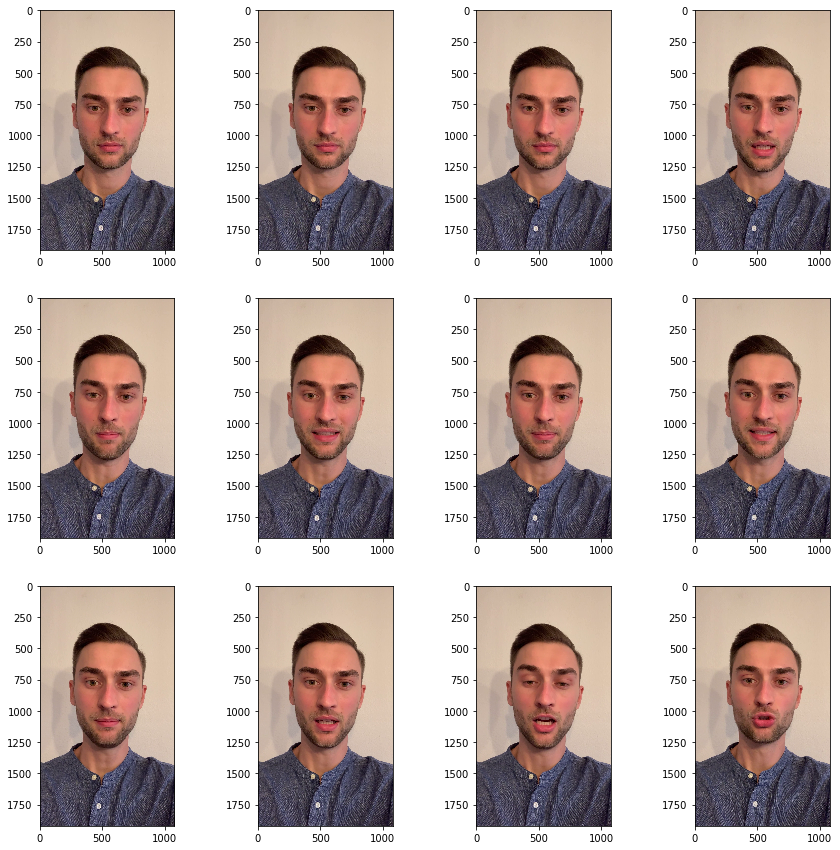

In [11]:
path_video = "presentation/data/driver.mp4"
video = imageio.get_reader(path_video)

frames = [f for f in video]
first_frames = [frames[i] for i in range(0,84,7)]
plot_images(first_frames)

### Bounding Boxes

Für das Fake-Video werden nur die Bewegungen des Gesichts benötigt. Daher wird das Video entsprechend zugeschnitten.
In einem ersten Schritt wird in den einzelnen Frames nach dem Gesicht und gesucht:

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.torch/models/s3fd-619a316812.pth
100%|██████████| 89843225/89843225 [00:00<00:00, 93722995.33it/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-11f355bf06.pth.tar" to /root/.torch/models/2DFAN4-11f355bf06.pth.tar
100%|██████████| 95641761/95641761 [00:00<00:00, 97472432.03it/s]


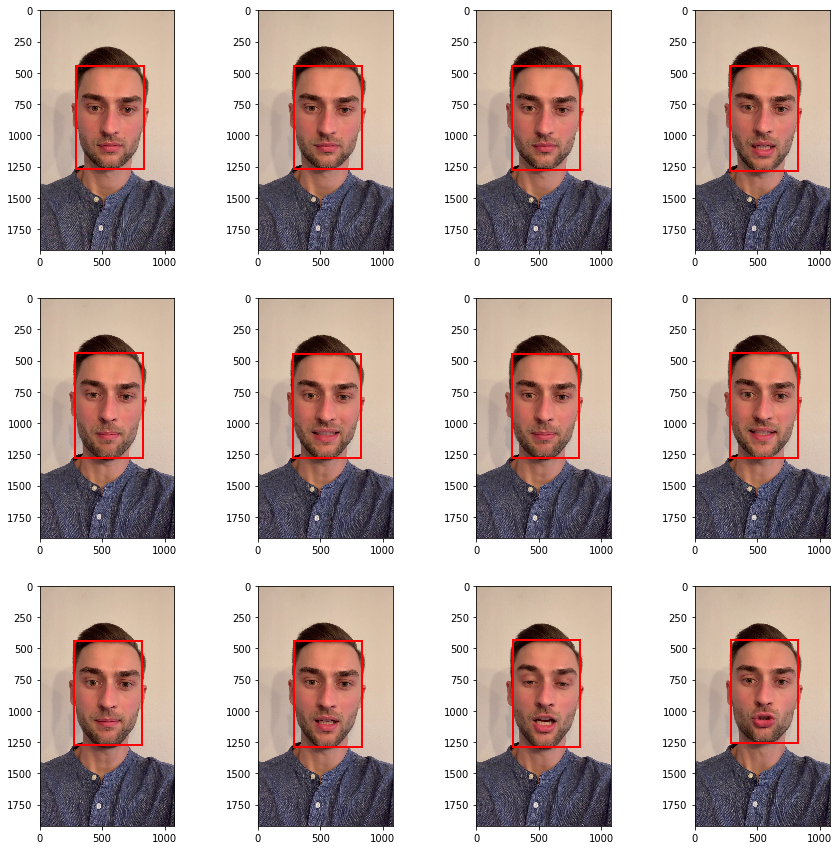

In [12]:
device = 'cuda'
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device=device)

def extract_bbox(frame, fa):
    if max(frame.shape[0], frame.shape[1]) > 640:
        scale_factor =  max(frame.shape[0], frame.shape[1]) / 640.0
        frame = resize(frame, (int(frame.shape[0] / scale_factor), int(frame.shape[1] / scale_factor)))
        frame = img_as_ubyte(frame)
    else:
        scale_factor = 1
    frame = frame[..., :3]
    bboxes = fa.face_detector.detect_from_image(frame[..., ::-1])
    if len(bboxes) == 0:
        return []
    return np.array(bboxes)[:, :-1] * scale_factor

bboxes = []
for frame in first_frames:
    bboxes.append(extract_bbox(frame, fa))
plot_images(first_frames, bboxes)

Jedes Frame hat die Bounding Box (das rote Rechteck) an einer anderen Position. Deshalb wird ein Bildausschnitt definiert, der grösser ist als sämtliche Bounding Boxes und diese umschliesst. Zusätzlich wird eine Toleranz hinzu addiert, bevor das Video zugeschnitten wird.

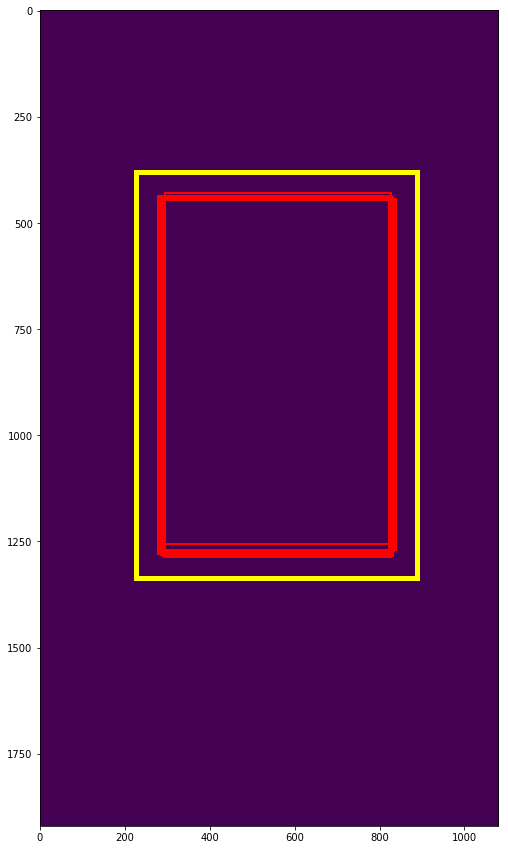

In [13]:
x, y = [], []
tol = 50
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.ones((1920, 1080)))
for bbox in bboxes:
    (x1, y1, x2, y2) = bbox.flatten()
    ax.add_patch(mpatches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
    x.append(x1), x.append(x2), y.append(y1), y.append(y2)
ax.add_patch(mpatches.Rectangle((np.min(x)-tol, np.min(y)-tol), np.max(x)-np.min(x)+2*tol, np.max(y)-np.min(y)+2*tol, fill=False, edgecolor='yellow', linewidth=5))
plt.show()

In [14]:
driv_video = "presentation/crop.mp4"
img = "presentation/data/parmelin.jpg"

### Video zuschneiden

Nachdem der gewünschte Bildausschnitt definiert wurde, kann das Video entsprechend zugeschnitten werden. Zusätzlich wird die Grösse von jedem Frame verkleinert, um die Laufzeit des Algorithmus zu reduzieren:

In [15]:
!python crop-video.py --inp presentation/data/driver.mp4

190it [00:46,  4.10it/s]
ffmpeg -i presentation/data/driver.mp4 -ss 0.0 -t 6.306306306306307 -filter:v "crop=1072:1074:0:315, scale=256:256" crop.mp4
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --ena

In [19]:
mp4 = open(driv_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Bild laden

Neben dem Video wird auch das Bild von Guy Parmelin benötigt:

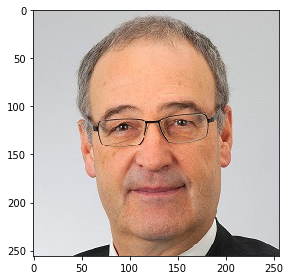

In [20]:
skimage.io.imshow(img)

# Deep Fake

Nachdem die Daten vorbereitet sind, kann das Deep-Fake Video erzeugt werden. Dies funktioniert mit zwei Modulen


1. Modul zur Bewegungsabschätzung
2. Modul zur Bilderzeugung


### Modul zur Bewegungsabschätzung
- Ein neuronales Netzwerk lernt in Bildern Schlüsselpunkte zu erkennen. Wenn die Schlüsselpunkte aus einzelnen Videoframes verglichen werden, können die Bewegungen abgeschätzt werden

![Keypoints](https://github.com/sagerpascal/first-order-model/blob/master/presentation/data/keypoints.png?raw=1)

- Die Bewegungen werden dann kodiert an das Modul zur Bilderzeugung übergeben


### Modul zur Bilderzeugung

- Das zweite Modul erzeugt das Bild. Dazu schätzt es ab, welche Bewegungen durch Verzerren des Bildes bewirkt werden können und wo das Bild "übermalt" werden soll

<img src="https://github.com/sagerpascal/first-order-model/blob/master/presentation/data/keypoints_gen.png?raw=1" alt="Keypoints" width="300"/>


- Anschliessend werden die angepassten Bilder zu einem Video zusammengefügt

<br>
<br>
<br>


### Training

Ein neuronales Netzwerk erlernt wie es diese Aufgaben vollautomatisch erfüllen kann. Dieses Erlernen erfordert jedoch viel Rechenleistung und dauert lange.

Deshalb verwendet wir dieses Beispiel ein bereits trainiertes Netzwerk:

In [21]:
def load_checkpoints(config_path, checkpoint_path, cpu=True):

    with open(config_path) as f:
        config = yaml.load(f)

    generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
    if not cpu:
        generator.cuda()

    kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                             **config['model_params']['common_params'])
    if not cpu:
        kp_detector.cuda()
    
    if cpu:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_path)
 
    generator.load_state_dict(checkpoint['generator'])
    kp_detector.load_state_dict(checkpoint['kp_detector'])
    
    if not cpu:
        generator = DataParallelWithCallback(generator)
        kp_detector = DataParallelWithCallback(kp_detector)

    generator.eval()
    kp_detector.eval()
    
    return generator, kp_detector

Das neuronale Netzwerk sucht zuerst die Schlüsselpunkte im Bild und danach im Video. Anhand dieser Daten wird dann das neue Video erzeugt: 

In [22]:
def make_animation(source_image, driving_video, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=True):
    with torch.no_grad():
        predictions = []
        source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source = source.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
        kp_source = kp_detector(source)
        kp_driving_initial = kp_detector(driving[:, :, 0])

        for frame_idx in tqdm(range(driving.shape[2])):
            driving_frame = driving[:, :, frame_idx]
            if not cpu:
                driving_frame = driving_frame.cuda()
            kp_driving = kp_detector(driving_frame)
            kp_norm = normalize_kp(kp_source=kp_source, kp_driving=kp_driving,
                                   kp_driving_initial=kp_driving_initial, use_relative_movement=relative,
                                   use_relative_jacobian=relative, adapt_movement_scale=adapt_movement_scale)
            out = generator(source, kp_source=kp_source, kp_driving=kp_norm)

            predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
    return predictions

Damit das Resultat noch realistischer aussieht kann ein Trick verwendet werden: Anstatt dass das erste Frame des Video als Ausgangsbild verwendet wird, wird das gesamte Video nach einem Frame durchsucht, welches am ehesten dem Bild von Herrn Parmelin entspricht. Danach wird das Video von diesem Frame ausgehend je einmal vorwärts und einmal rückwärts generiert. Am Ende werden die beiden generierten Videos in der korrekten Reihenfolge zusammengesetzt:

In [33]:
def find_best_frames(source, driving, n_frames=20, cpu=True):

    def normalize_kp(kp):
        kp = kp - kp.mean(axis=0, keepdims=True)
        area = ConvexHull(kp[:, :2]).volume
        area = np.sqrt(area)
        kp[:, :2] = kp[:, :2] / area
        return kp

    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=True, device='cpu' if cpu else 'cuda')
    kp_source = fa.get_landmarks(255 * source)[0]
    kp_source = normalize_kp(kp_source)

    frame_norm = {}
    for i, image in tqdm(enumerate(driving)):
        kp_driving = fa.get_landmarks(255 * image)[0]
        kp_driving = normalize_kp(kp_driving)
        f_norm = np.sum(np.abs(kp_source - kp_driving) ** 2)
        frame_norm[i] = f_norm
    sorted_frame_norm = dict(reversed(sorted(frame_norm.items(), key=lambda kv: kv[1])))
    best_frames = list(sorted_frame_norm.keys())[:n_frames]
    return fa, best_frames

Anstatt das erste Frame (mitte) verwenden wir nun also das für den Algorithmus "beste" Frame (rechts) um die Bewegungen zu berechnen:




0it [00:00, ?it/s]


1it [00:03,  3.57s/it]

3.569086790084839





2it [00:07,  3.59s/it]

7.171915054321289





3it [00:10,  3.61s/it]

10.814557552337646





4it [00:14,  3.63s/it]

14.477313041687012





5it [00:18,  3.62s/it]

18.037360429763794





6it [00:21,  3.61s/it]

21.62208342552185





7it [00:25,  3.61s/it]

25.25019407272339





8it [00:28,  3.61s/it]

28.854240894317627





9it [00:32,  3.61s/it]

32.45462107658386





10it [00:36,  3.62s/it]

36.136170387268066





11it [00:39,  3.62s/it]

39.755995988845825





12it [00:43,  3.62s/it]

43.35228776931763





13it [00:47,  3.63s/it]

47.0576491355896





14it [00:50,  3.63s/it]

50.68471169471741





15it [00:54,  3.63s/it]

54.28417205810547





16it [00:58,  3.63s/it]

57.93682336807251





17it [01:01,  3.63s/it]

61.55580997467041





18it [01:05,  3.63s/it]

65.1832628250122





19it [01:08,  3.63s/it]

68.83452916145325





20it [01:12,  3.63s/it]

72.49206209182739





21it [01:16,  3.63s/it]

76.1222403049469





22it [01:19,  3.63s/it]

79.77073907852173





23it [01:23,  3.63s/it]

83.36591720581055





24it [01:27,  3.63s/it]

86.9844400882721





25it [01:30,  3.63s/it]

90.63307905197144





26it [01:34,  3.63s/it]

94.28022384643555





27it [01:38,  3.64s/it]

98.00786232948303





28it [01:41,  3.64s/it]

101.63086223602295





29it [01:45,  3.64s/it]

105.26065301895142





30it [01:49,  3.64s/it]

108.88242745399475





31it [01:52,  3.64s/it]

112.49289464950562





32it [01:56,  3.64s/it]

116.11233925819397





33it [02:00,  3.64s/it]

119.76906323432922





34it [02:03,  3.64s/it]

123.44578719139099





35it [02:07,  3.64s/it]

127.09773111343384





36it [02:11,  3.64s/it]

130.7470474243164





37it [02:14,  3.64s/it]

134.38395857810974





38it [02:18,  3.64s/it]

137.99007630348206





39it [02:21,  3.64s/it]

141.61424899101257





40it [02:25,  3.64s/it]

145.23686599731445





41it [02:29,  3.64s/it]

148.8776876926422





42it [02:32,  3.64s/it]

152.5170259475708





43it [02:36,  3.64s/it]

156.26374006271362





44it [02:40,  3.64s/it]

159.94149017333984





45it [02:43,  3.64s/it]

163.5875906944275





46it [02:47,  3.64s/it]

167.23193979263306





47it [02:51,  3.64s/it]

170.8406994342804





48it [02:54,  3.64s/it]

174.4544973373413





49it [02:58,  3.64s/it]

178.08313703536987





50it [03:02,  3.64s/it]

181.7137966156006





51it [03:05,  3.64s/it]

185.3248748779297





52it [03:09,  3.64s/it]

188.90588212013245





53it [03:12,  3.64s/it]

192.50280117988586





54it [03:16,  3.64s/it]

196.13120818138123





55it [03:20,  3.64s/it]

199.72549653053284





56it [03:23,  3.64s/it]

203.32842326164246





57it [03:27,  3.64s/it]

206.89907789230347





58it [03:30,  3.64s/it]

210.49613976478577





59it [03:34,  3.64s/it]

214.02622723579407





60it [03:38,  3.63s/it]

217.58604216575623





61it [03:41,  3.63s/it]

221.13504767417908





62it [03:45,  3.63s/it]

224.70364236831665





63it [03:48,  3.63s/it]

228.2717568874359





64it [03:52,  3.63s/it]

231.8530957698822





65it [03:55,  3.63s/it]

235.41055727005005





66it [03:59,  3.63s/it]

238.9448277950287





67it [04:02,  3.63s/it]

242.45336842536926





68it [04:06,  3.63s/it]

246.0066101551056





69it [04:10,  3.62s/it]

249.54620838165283





70it [04:13,  3.62s/it]

253.11565041542053





71it [04:17,  3.62s/it]

256.63743925094604





72it [04:20,  3.62s/it]

260.2174916267395





73it [04:24,  3.62s/it]

263.76384449005127





74it [04:27,  3.62s/it]

267.34812903404236





75it [04:31,  3.62s/it]

270.91328740119934





76it [04:35,  3.62s/it]

274.4999096393585





77it [04:38,  3.62s/it]

278.0864164829254





78it [04:42,  3.62s/it]

281.7039415836334





79it [04:45,  3.62s/it]

285.304842710495





80it [04:49,  3.62s/it]

288.94184398651123





81it [04:53,  3.62s/it]

292.5113205909729





82it [04:56,  3.62s/it]

296.0610251426697





83it [05:00,  3.62s/it]

299.6285881996155





84it [05:03,  3.62s/it]

303.189457654953





85it [05:07,  3.62s/it]

306.74154591560364





86it [05:10,  3.62s/it]

310.2971134185791





87it [05:14,  3.62s/it]

313.87054324150085





88it [05:18,  3.62s/it]

317.4401354789734





89it [05:21,  3.61s/it]

320.98590636253357





90it [05:25,  3.61s/it]

324.53311562538147





91it [05:28,  3.61s/it]

328.0741674900055





92it [05:32,  3.61s/it]

331.5738089084625





93it [05:35,  3.61s/it]

335.1394793987274





94it [05:39,  3.61s/it]

338.66814613342285





95it [05:42,  3.61s/it]

342.2032837867737





96it [05:46,  3.61s/it]

345.7454857826233





97it [05:50,  3.61s/it]

349.2905433177948





98it [05:53,  3.61s/it]

352.8471665382385





99it [05:57,  3.61s/it]

356.35997772216797





100it [06:00,  3.61s/it]

359.89774894714355





101it [06:04,  3.61s/it]

363.45121359825134





102it [06:07,  3.61s/it]

367.0027906894684





103it [06:11,  3.61s/it]

370.5004301071167





104it [06:14,  3.60s/it]

374.02122926712036





105it [06:18,  3.60s/it]

377.56863164901733





106it [06:21,  3.60s/it]

381.0720739364624





107it [06:25,  3.60s/it]

384.6019699573517





108it [06:28,  3.60s/it]

388.1174635887146





109it [06:32,  3.60s/it]

391.6150527000427





110it [06:36,  3.60s/it]

395.2018611431122





111it [06:39,  3.60s/it]

398.7240934371948





112it [06:43,  3.60s/it]

402.28875970840454





113it [06:46,  3.60s/it]

405.8221695423126





114it [06:50,  3.60s/it]

409.3274919986725





115it [06:53,  3.60s/it]

412.8598985671997





116it [06:57,  3.60s/it]

416.40458941459656





117it [07:00,  3.60s/it]

419.9661228656769





118it [07:04,  3.60s/it]

423.53453946113586





119it [07:08,  3.60s/it]

427.07593607902527





120it [07:11,  3.60s/it]

430.63783526420593





121it [07:15,  3.60s/it]

434.20781326293945





122it [07:18,  3.60s/it]

437.7469470500946





123it [07:22,  3.60s/it]

441.30738401412964





124it [07:25,  3.60s/it]

444.8307557106018





125it [07:29,  3.60s/it]

448.41871643066406





126it [07:33,  3.60s/it]

451.99396085739136





127it [07:36,  3.60s/it]

455.639760017395





128it [07:40,  3.60s/it]

459.26901602745056





129it [07:43,  3.60s/it]

462.8908586502075





130it [07:47,  3.60s/it]

466.47474551200867





131it [07:51,  3.60s/it]

470.07374382019043





132it [07:54,  3.60s/it]

473.6887102127075





133it [07:58,  3.60s/it]

477.28825640678406





134it [08:01,  3.60s/it]

480.8691928386688





135it [08:05,  3.60s/it]

484.46604585647583





136it [08:09,  3.60s/it]

488.03796315193176





137it [08:12,  3.60s/it]

491.6406180858612





138it [08:16,  3.60s/it]

495.2201473712921





139it [08:19,  3.60s/it]

498.8012363910675





140it [08:23,  3.60s/it]

502.3973686695099





141it [08:27,  3.60s/it]

506.0409369468689





142it [08:30,  3.60s/it]

509.6296601295471





143it [08:34,  3.60s/it]

513.213766336441





144it [08:38,  3.60s/it]

516.837671995163





145it [08:41,  3.60s/it]

520.409734249115





146it [08:45,  3.60s/it]

524.0309114456177





147it [08:48,  3.60s/it]

527.6138088703156





148it [08:52,  3.60s/it]

531.229302406311





149it [08:56,  3.60s/it]

534.8347821235657





150it [08:59,  3.60s/it]

538.419203042984





151it [09:03,  3.60s/it]

541.9693033695221





152it [09:06,  3.60s/it]

545.5245056152344





153it [09:10,  3.60s/it]

549.0633482933044





154it [09:13,  3.60s/it]

552.619731426239





155it [09:17,  3.60s/it]

556.1557178497314





156it [09:20,  3.60s/it]

559.6612546443939





157it [09:24,  3.60s/it]

563.1663539409637





158it [09:27,  3.59s/it]

566.704803943634





159it [09:31,  3.59s/it]

570.2212285995483





160it [09:35,  3.59s/it]

573.7417366504669





161it [09:38,  3.59s/it]

577.214408159256





162it [09:42,  3.59s/it]

580.7247371673584





163it [09:45,  3.59s/it]

584.2561595439911





164it [09:49,  3.59s/it]

587.7832691669464





165it [09:52,  3.59s/it]

591.3355462551117





166it [09:56,  3.59s/it]

595.0493886470795





167it [09:59,  3.59s/it]

598.6144587993622





168it [10:03,  3.59s/it]

602.1614723205566





169it [10:07,  3.59s/it]

605.7173202037811





170it [10:10,  3.59s/it]

609.2687299251556





171it [10:14,  3.59s/it]

612.8433873653412





172it [10:17,  3.59s/it]

616.4209976196289





173it [10:21,  3.59s/it]

619.9961602687836





174it [10:24,  3.59s/it]

623.5732998847961





175it [10:28,  3.59s/it]

627.0959758758545





176it [10:32,  3.59s/it]

630.6057291030884





177it [10:35,  3.59s/it]

634.1198108196259





178it [10:39,  3.59s/it]

637.6748564243317





179it [10:42,  3.59s/it]

641.1933653354645





180it [10:46,  3.59s/it]

644.727240562439





181it [10:49,  3.59s/it]

648.2419378757477





182it [10:53,  3.59s/it]

651.777941942215





183it [10:56,  3.59s/it]

655.3484165668488





184it [11:00,  3.59s/it]

658.9410834312439





185it [11:04,  3.59s/it]

662.507506608963





186it [11:07,  3.59s/it]

666.0777037143707





187it [11:11,  3.59s/it]

669.6623768806458





188it [11:14,  3.59s/it]




673.2799937725067


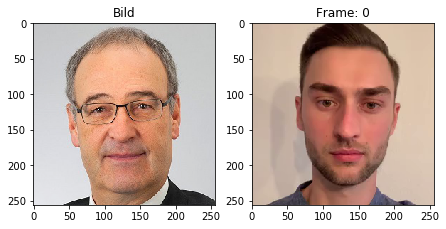

In [34]:
cpu = False

source_image = imageio.imread(img)
reader = imageio.get_reader(driv_video)
driving_video = [f for f in reader]
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

fa, best_frames = find_best_frames(source_image, driving_video, cpu)

images, titles = [], []
images.append(source_image)
titles.append("Bild")
images.append(driving_video[0])
titles.append("Frame: {}".format(0))

for f in best_frames:
    images.append(driving_video[f])
    titles.append("Frame: {}".format(f))

plot_images(images, titles=titles)

Nachdem sämtliche Funktionen definiert sind, müssen diese nur noch ausgeführt werden:

In [27]:
fps = reader.get_meta_data()['fps']
config = "config/vox-adv-256.yaml"
checkpoint = "checkpoints/vox-adv-cpk.pth.tar"
result = "result.mp4"


generator, kp_detector = load_checkpoints(config_path=config, checkpoint_path=checkpoint, cpu=cpu)

i = 0  # TODO =best_frame
driving_forward = driving_video[i:]
driving_backward = driving_video[:(i+1)][::-1]
predictions_forward = make_animation(source_image, driving_forward, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=cpu)
predictions_backward = make_animation(source_image, driving_backward, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=cpu)
predictions = predictions_backward[::-1] + predictions_forward[1:]
imageio.mimsave(result, [img_as_ubyte(frame) for frame in predictions], fps=fps)



  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:05<15:39,  5.02s/it]

  1%|          | 2/188 [00:05<07:56,  2.56s/it]

  2%|▏         | 4/188 [00:05<04:04,  1.33s/it]

  3%|▎         | 6/188 [00:05<02:47,  1.09it/s]

  4%|▎         | 7/188 [00:05<02:25,  1.25it/s]

  4%|▍         | 8/188 [00:05<02:08,  1.40it/s]

  5%|▍         | 9/188 [00:05<01:55,  1.55it/s]

  6%|▌         | 11/188 [00:06<01:36,  1.83it/s]

  6%|▋         | 12/188 [00:06<01:29,  1.96it/s]

  7%|▋         | 13/188 [00:06<01:23,  2.09it/s]

  7%|▋         | 14/188 [00:06<01:18,  2.21it/s]

  8%|▊         | 15/188 [00:06<01:14,  2.34it/s]

  9%|▉         | 17/188 [00:06<01:06,  2.57it/s]

 10%|▉         | 18/188 [00:06<01:03,  2.68it/s]

 10%|█         | 19/188 [00:06<01:00,  2.78it/s]

 11%|█         | 20/188 [00:06<00:58,  2.89it/s]

 12%|█▏        | 22/188 [00:07<00:53,  3.09it/s]

 12%|█▏        | 23/188 [00:07<00:51,  3.18it/s]

 13%|█▎        | 24/188 [00:07<00:50,  3.28it/s]

 13%|█▎       

### Videos zusammenfügen

Damit das Resultat besser ersichtlich ist, wird das originale sowie das erzeugte Video zusammengefügt.

In [28]:
os.system("ffmpeg -i crop.mp4 -i result.mp4 -filter_complex hstack finished_video.mp4")

0

### Resultat

In [29]:
os.system("ffmpeg -i crop.mp4 -i result.mp4 -filter_complex hstack finished_video.mp4")

256

### Resultat

In [30]:
mp4 = open("finished_video.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Weitere Möglichkeiten

### Verschiedene Annimationen:

![Screenshot](https://github.com/sagerpascal/first-order-model/blob/master/sup-mat/vox-teaser.gif?raw=1)

![Screenshot](https://github.com/sagerpascal/first-order-model/blob/master/sup-mat/fashion-teaser.gif?raw=1)

![Screenshot](https://github.com/sagerpascal/first-order-model/blob/master/sup-mat/mgif-teaser.gif?raw=1)


### Face Swap

![Screenshot](https://github.com/sagerpascal/first-order-model/blob/master/sup-mat/face-swap.gif?raw=1)